In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import util

import matplotlib.pyplot as plt
import tensorflow as tf

# MNIST loader

In [69]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000, 28, 28, 1)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

train_bf = util.BatchFeeder(X[index[:54000]], Y[index[:54000]], 128)
valid_bf = util.BatchFeeder(X[index[54000:]], Y[index[54000:]], 32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Generative adversarial nets code

In [85]:
class GAN:
    def __init__(self, latent_dim=5):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Define parameters of the encoder
        self.input_dim = (28, 28, 1)
        
        # Dimension of the sub-netowrks.
        self.latent_dim = latent_dim
        self.generator_dim = [128, 64, 32, 1]
        self.discriminator_dim = [32, 64, 128, 1]
        self.batchsize = 128
        self.filtersize = (3,3)
        
        # Activation function is tf.nn.elu
        self.gen_fn = tf.nn.relu
        self.dis_fn = tf.nn.elu
        
        # Other parameters
        self.learning_rate = 0.001
        self.g_lr = 0.001 # 0.0025
        self.d_lr = 0.0005 # 1e-5
        
        # Build netowrk
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        
        # Tracking data
        self.learning_curve = []
        self.record = {"generated":[]}
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
    
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
        
        x = tf.placeholder(tf.float32, shape=[self.batchsize]+list(self.input_dim), name="x")
        z = tf.random_normal(shape=[self.batchsize, self.latent_dim])
        bn = tf.placeholder(tf.bool, shape=[])
        
        
        # defining G(z)
        gz = self.generator(z, bn)
        
        # making sure that the dimesionality of inputs matches.
        assert gz.shape == x.shape
        
        # defining D(G(z)) and D(x)
        dgz, dgz_pre = self.discriminator(gz, bn)
        dx, dx_pre = self.discriminator(x, bn, reuse=True)
        
        # Compute losses
        d_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dx_pre, labels=tf.ones_like(dx))\
        + tf.nn.sigmoid_cross_entropy_with_logits(logits=dgz_pre, labels=tf.zeros_like(dgz))
        d_loss = tf.reduce_mean(d_loss)
        
        g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dgz_pre, labels=tf.ones_like(dgz))
        g_loss = tf.reduce_mean(g_loss)
        
        # Compute discriminator accuracy
        x_correct = tf.reduce_sum(tf.cast(dx > 0.5, tf.int32))
        z_correct = tf.reduce_sum(tf.cast(dgz < 0.5, tf.int32))
        acc = tf.divide(x_correct + z_correct, 2 * self.batchsize)
        
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            # Define optimizers
            opt_g = tf.train.AdamOptimizer(learning_rate=self.g_lr,beta1=0.5)
            opt_d = tf.train.AdamOptimizer(learning_rate=self.d_lr, beta1=0.5)
            
            # Get weights
            g_vars = [v for v in tf.trainable_variables() if "generator" in v.name]
            d_vars = [v for v in tf.trainable_variables() if "discriminator" in v.name]
            
            # Defining training processs for generator
            grads_and_vars = opt_g.compute_gradients(g_loss, g_vars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train_g = opt_g.apply_gradients(clipped, name="minimize_g_loss")
            
            # Defining training processs for generator
            grads_and_vars = opt_d.compute_gradients(d_loss, d_vars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train_d = opt_d.apply_gradients(clipped, name="minimize_d_loss")
            
        # Building independent generator
        z_ = tf.placeholder_with_default(tf.random_normal([self.batchsize, self.latent_dim]),
                                            shape=[self.batchsize, self.latent_dim],
                                            name="latent_input")
        gz_ = self.generator(z, bn, reuse=True)
        
        # Exporting out the operaions as dictionary
        return dict(
            x = x,
            z = z,
            generated = gz,
            z_ = z_,
            generated_ = gz_,
            dx = dx,
            dgz = dgz,
            d_loss = d_loss,
            g_loss = g_loss,
            train_d = train_d,
            train_g = train_g,
            acc = acc,
            bn = bn
        )
    
    def discriminator(self, _input, bn, reuse=None):
        with tf.variable_scope("discriminator", reuse=reuse):
            
            # layer 1
            n_filt = self.discriminator_dim[0]
            layer1 = tf.layers.conv2d(_input, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer1 = tf.contrib.layers.batch_norm(layer1, is_training=bn)
            layer1 = self.dis_fn(layer1)
            
            # layer 2
            n_filt = self.discriminator_dim[1]
            layer2 = tf.layers.conv2d(layer1, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
            layer2 = self.dis_fn(layer2)
            
            # layer 3
            n_filt = self.discriminator_dim[2]
            layer3 = tf.layers.conv2d(layer2, n_filt, self.filtersize, strides=(2,2), padding="valid", activation=None)
            layer3 = tf.contrib.layers.batch_norm(layer3, is_training=bn)
            layer3 = self.dis_fn(layer3)
            
            # layer 4
            n_filt = self.discriminator_dim[3]
            layer4 = tf.layers.conv2d(layer3, n_filt, self.filtersize, strides=(1,1), padding="valid", activation=None)
            layer4 = tf.contrib.layers.batch_norm(layer4, is_training=bn)
            output = tf.nn.sigmoid(layer4)
            
            print "===D==="
            print layer1
            print layer2
            print layer3
            print layer4
            print 
            
            return output, layer4
        
    
    def generator(self, _input, bn, reuse=None):
        
        with tf.variable_scope("generator", reuse=reuse):
            _input = tf.reshape(_input, (self.batchsize, 1, 1, self.latent_dim))
            
            # layer 1 (outputs: 512x4x4x4)
            n_filt = self.generator_dim[0]
            layer1 = tf.layers.conv2d_transpose(_input, n_filt, self.filtersize, strides=(1,1), padding="valid", activation=None)
            layer1 = tf.contrib.layers.batch_norm(layer1, is_training=bn)
            layer1 = self.gen_fn(layer1)
            
            # layer 2 (outputs: 256x8x8x8)
            n_filt = self.generator_dim[1]
            layer2 = tf.layers.conv2d_transpose(layer1, n_filt, self.filtersize, strides=(2,2), padding="valid", activation=None)
            layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
            layer2 = self.gen_fn(layer2)
            
            # layer 3 (outputs: 128x16x16x16)
            n_filt = self.generator_dim[2]
            layer3 = tf.layers.conv2d_transpose(layer2, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer3 = tf.contrib.layers.batch_norm(layer3, is_training=bn)
            layer3 = self.gen_fn(layer3)
            
            # layer 4 (outputs: 64x32x32x32)
            n_filt = self.generator_dim[3]
            layer4 = tf.layers.conv2d_transpose(layer3, n_filt, self.filtersize, strides=(2,2), padding="same", activation=None)
            layer4 = tf.contrib.layers.batch_norm(layer4, is_training=bn)
            layer4 = tf.nn.sigmoid(layer4)
            
            print "===G==="
            print layer1
            print layer2
            print layer3
            print layer4
            print
            
            return layer4
        
    def decode(self, z=None):
        feed_dict = dict()
        if z is not None:
            feed_dict = {self.ops["z_"]: z, self.ops["bn"]: False}
        else:
            feed_dict = {self.ops["bn"]: False}
        return self.sesh.run(self.ops["generated_"], feed_dict)
    
    # Closing session
    def close(self):
        self.sesh.close()
        
    def train(self, X, epochs):
        # Making the saver object.
        saver = tf.train.Saver()
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X.n*1.0/X.batch_size))
        
        e = 0
        while e < epochs:
            epoch_cost = {"dloss":[], "gloss":[]}
            
            if e == epochs-1: self.latent_record = {"generated":[]}
            
            for i in range(batch_num):
                
                #if i%(batch_num/10)==0:
                #    print i, batch_num
                #Training happens here.
                batch = X.next()
                feed_dict = {self.ops["x"]: batch[0], self.ops["bn"]: True}
                
                #Compute loss
                d_loss = self.sesh.run(self.ops["d_loss"], feed_dict)
                g_loss = self.sesh.run(self.ops["g_loss"], feed_dict)
                acc = self.sesh.run(self.ops["acc"], feed_dict)
                generated = self.sesh.run(self.ops["generated"], feed_dict)
                
                if acc < 0.8: # make it a parameter
                    self.sesh.run(self.ops["train_d"], feed_dict)
                self.sesh.run(self.ops["train_g"], feed_dict)
                
                #Record what you need
                if e == epochs-1: self.record["generated"] = self.record["generated"] + [_ for _ in generated]
                epoch_cost["dloss"].append(d_loss)
                epoch_cost["gloss"].append(g_loss)
            
            self.e+=1
            e+= 1
                
            print "Epoch:"+str(self.e), "Loss(D)", d_loss, "Loss(G)", g_loss
            self.learning_curve.append(epoch_cost)

# Training on MNIST data

In [86]:
m = GAN()

===G===
Tensor("generator/Relu:0", shape=(128, 3, 3, 128), dtype=float32)
Tensor("generator/Relu_1:0", shape=(128, 7, 7, 64), dtype=float32)
Tensor("generator/Relu_2:0", shape=(128, 14, 14, 32), dtype=float32)
Tensor("generator/Sigmoid:0", shape=(128, 28, 28, 1), dtype=float32)

===D===
Tensor("discriminator/Elu:0", shape=(128, 14, 14, 32), dtype=float32)
Tensor("discriminator/Elu_1:0", shape=(128, 7, 7, 64), dtype=float32)
Tensor("discriminator/Elu_2:0", shape=(128, 3, 3, 128), dtype=float32)
Tensor("discriminator/BatchNorm_3/batchnorm/add_1:0", shape=(128, 1, 1, 1), dtype=float32)

===D===
Tensor("discriminator_1/Elu:0", shape=(128, 14, 14, 32), dtype=float32)
Tensor("discriminator_1/Elu_1:0", shape=(128, 7, 7, 64), dtype=float32)
Tensor("discriminator_1/Elu_2:0", shape=(128, 3, 3, 128), dtype=float32)
Tensor("discriminator_1/BatchNorm_3/batchnorm/add_1:0", shape=(128, 1, 1, 1), dtype=float32)

===G===
Tensor("generator_1/Relu:0", shape=(128, 3, 3, 128), dtype=float32)
Tensor("genera

In [92]:
m.train(train_bf, 10)

Epoch:11 Loss(D) 1.4499 Loss(G) 0.67169
Epoch:12 Loss(D) 1.42604 Loss(G) 0.672659
Epoch:13 Loss(D) 1.43861 Loss(G) 0.671837
Epoch:14 Loss(D) 1.44657 Loss(G) 0.671813
Epoch:15 Loss(D) 1.44773 Loss(G) 0.672474
Epoch:16 Loss(D) 1.4297 Loss(G) 0.671443
Epoch:17 Loss(D) 1.45007 Loss(G) 0.672324
Epoch:18 Loss(D) 1.42573 Loss(G) 0.674065
Epoch:19 Loss(D) 1.42673 Loss(G) 0.674142
Epoch:20 Loss(D) 1.42681 Loss(G) 0.673574


# Resulting image

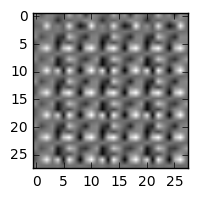

In [106]:
test = m.record["generated"][np.random.randint(50000)][:, :, 0]
plt.figure(figsize=(2,2))
plt.imshow(test, cmap="Greys")
plt.show()